In [ ]:
# базові імпорти та перехід у корінь проєкту

import os, sys

# ноубук лежить в /results, переходимо в корінь CV_Project
PROJECT_ROOT = os.path.abspath("..")
os.chdir(PROJECT_ROOT)
print("CWD:", os.getcwd())

import torch
import pandas as pd
import matplotlib.pyplot as plt

# щоб імпорти працювали
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from config import DEVICE
from utils.dataset import get_dataloaders
from models.transfer_models import get_resnet18, get_efficientnet_b0
from utils.train_utils import eval_one_epoch 

print("Using device:", DEVICE)
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


CWD: c:\University\4course\CV_Project
Using device: cuda
GPU: NVIDIA GeForce RTX 4060 Ti


In [ ]:
# helper-функції для моделей та оцінки

import torch.nn as nn

def build_model(model_name: str, num_classes: int, feature_extract: bool):
    if model_name == "resnet18":
        model = get_resnet18(num_classes=num_classes, feature_extract=feature_extract)
    elif model_name == "efficientnet_b0":
        model = get_efficientnet_b0(num_classes=num_classes, feature_extract=feature_extract)
    else:
        raise ValueError(f"Unknown model_name: {model_name}")
    return model


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def evaluate_on_loader(model, loader, device):
    """Проста оцінка accuracy на переданому loader."""
    model.eval()
    correct, total, running_loss = 0, 0, 0.0
    criterion = nn.CrossEntropyLoss().to(device)

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc


In [ ]:
# завантаження train/val даних (для оцінки моделей)

train_loader, val_loader, class_names = get_dataloaders()
num_classes = len(class_names)

print("Classes:", class_names)
print("Train size:", len(train_loader.dataset))
print("Val size:", len(val_loader.dataset))


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train size: 14034
Val size: 3000


In [ ]:
# завантаження summary таблиці по моделях

summary_path = "results/transfer_summary.csv"
df = pd.read_csv(summary_path)

df


,model_name,mode,val_acc,params,train_time_min,ckpt_path
0,resnet18,fe,0.905000,3078,5.684271,checkpoints\resnet18_fe_best.pth
1,resnet18,ft,0.929333,11179590,4.184796,checkpoints\resnet18_ft_best.pth
2,efficientnet_b0,fe,0.881667,7686,6.387741,checkpoints\efficientnet_b0_fe_best.pth
3,efficientnet_b0,ft,0.942333,4015234,14.231809,checkpoints\efficientnet_b0_ft_best.pth


In [ ]:
# базовий аналіз

print("За замовчуванням, сортуємо за val_acc (спадаюче):")
df_sorted = df.sort_values(by="val_acc", ascending=False)
df_sorted


За замовчуванням, сортуємо за val_acc (спадаюче):


,model_name,mode,val_acc,params,train_time_min,ckpt_path
3,efficientnet_b0,ft,0.942333,4015234,14.231809,checkpoints\efficientnet_b0_ft_best.pth
1,resnet18,ft,0.929333,11179590,4.184796,checkpoints\resnet18_ft_best.pth
0,resnet18,fe,0.905000,3078,5.684271,checkpoints\resnet18_fe_best.pth
2,efficientnet_b0,fe,0.881667,7686,6.387741,checkpoints\efficientnet_b0_fe_best.pth


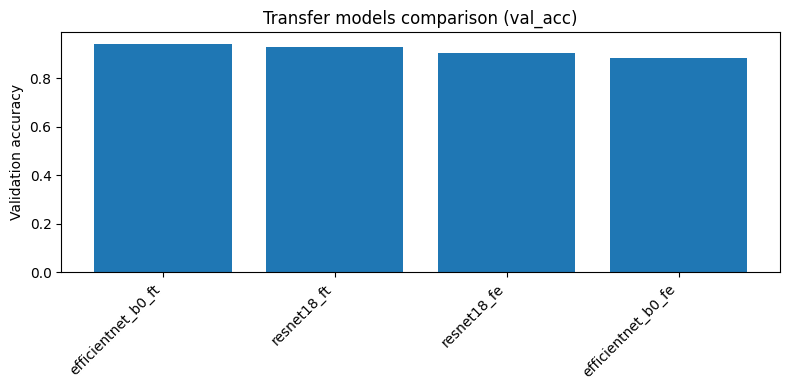

In [ ]:
# barplot val_acc по "model_name_mode"

plt.figure(figsize=(8, 4))

labels = df_sorted["model_name"] + "_" + df_sorted["mode"]
plt.bar(labels, df_sorted["val_acc"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Validation accuracy")
plt.title("Transfer models comparison (val_acc)")
plt.tight_layout()
plt.show()


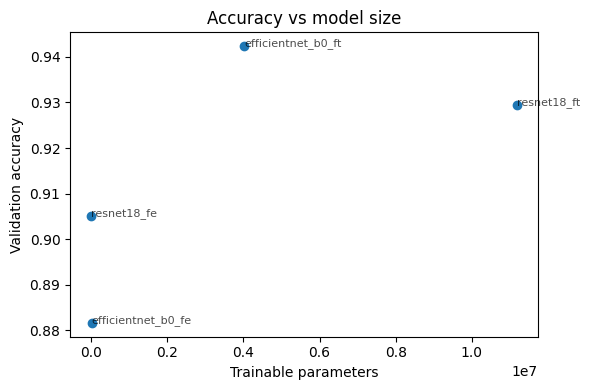

In [ ]:
# scatter plot params vs val_acc

plt.figure(figsize=(6, 4))
plt.scatter(df["params"], df["val_acc"])

for _, row in df.iterrows():
    label = f"{row['model_name']}_{row['mode']}"
    plt.annotate(label, (row["params"], row["val_acc"]), fontsize=8, alpha=0.7)

plt.xlabel("Trainable parameters")
plt.ylabel("Validation accuracy")
plt.title("Accuracy vs model size")
plt.tight_layout()
plt.show()


In [ ]:
# вибір найкращої моделі за val_acc

best_idx = df["val_acc"].idxmax()
best_row = df.loc[best_idx]

best_row


model_name                                efficientnet_b0
mode                                                   ft
val_acc                                          0.942333
params                                            4015234
train_time_min                                  14.231809
ckpt_path         checkpoints\efficientnet_b0_ft_best.pth
Name: 3, dtype: object

Best model: efficientnet_b0 mode: ft
Checkpoint: checkpoints\efficientnet_b0_ft_best.pth
Val loss: 0.2705, Val acc: 0.9423

Classification report:
              precision    recall  f1-score   support

   buildings       0.94      0.93      0.93       437
      forest       0.99      1.00      0.99       474
     glacier       0.93      0.88      0.91       553
    mountain       0.90      0.92      0.91       525
         sea       0.96      0.98      0.97       510
      street       0.94      0.95      0.94       501

    accuracy                           0.94      3000
   macro avg       0.94      0.94      0.94      3000
weighted avg       0.94      0.94      0.94      3000



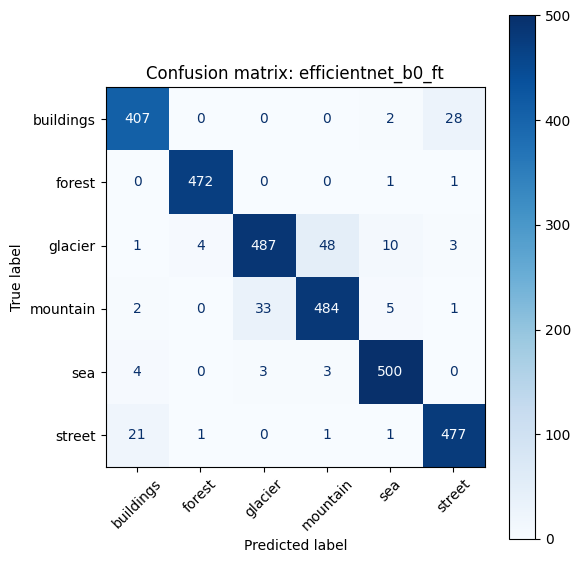

In [ ]:
# оцінка найкращої моделі на val_loader + confusion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

best_model_name = best_row["model_name"]
best_mode = best_row["mode"]
best_ckpt_path = best_row["ckpt_path"]
feature_extract = best_mode == "fe"

print("Best model:", best_model_name, "mode:", best_mode)
print("Checkpoint:", best_ckpt_path)

# 1) створюємо модель та вантажимо ваги
best_model = build_model(best_model_name, num_classes, feature_extract).to(DEVICE)
state_dict = torch.load(best_ckpt_path, map_location=DEVICE)
best_model.load_state_dict(state_dict)
best_model.eval()

# 2) оцінка на val_loader
val_loss, val_acc = evaluate_on_loader(best_model, val_loader, DEVICE)
print(f"Val loss: {val_loss:.4f}, Val acc: {val_acc:.4f}")

# 3) збираємо предикти для confusion matrix та звіту
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)
        outputs = best_model(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

print("\nClassification report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues")
plt.title(f"Confusion matrix: {best_model_name}_{best_mode}")
plt.tight_layout()
plt.show()


In [ ]:
# перевірка transfer_best.pth

transfer_best_path = "checkpoints/transfer_best.pth"
print("transfer_best.pth:", transfer_best_path)

# вантажимо ваги в ту ж архітектуру
transfer_model = build_model(best_model_name, num_classes, feature_extract).to(DEVICE)
transfer_state = torch.load(transfer_best_path, map_location=DEVICE)
transfer_model.load_state_dict(transfer_state)

# перевірка, що результати співпадають з best_model (можна обмежитись кількома батчами)
_, transfer_val_acc = evaluate_on_loader(transfer_model, val_loader, DEVICE)
print(f"Val acc через transfer_best.pth: {transfer_val_acc:.4f}")


transfer_best.pth: checkpoints/transfer_best.pth
Val acc через transfer_best.pth: 0.9423
